# Jacobian Classification Visualization

This notebook analyzes the separation between Memorized and Unmemorized prompts based on Conditional Jacobian Norms.
It performs analysis at two levels:
1. **Sample Level**: Using all individual noise samples (100 per prompt).
2. **Prompt Level**: Averaging the Jacobian Norms over the 100 samples for each prompt.

In [18]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set Style
sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 14})

In [19]:
# Load Data
base_dir = "/home/gpuadmin/cssin/cond_Jacobian/results/jacobian_classification_sd2_proj_1_m219_u219"
csv_path = os.path.join(base_dir, "jacobian_norms_results.csv")

if not os.path.exists(csv_path):
    raise FileNotFoundError(f"CSV file not found at {csv_path}")

df_results = pd.read_csv(csv_path)
print(f"Loaded {len(df_results)} samples.")

# Clean Data: Remove NaN and Infinity
import numpy as np
initial_len = len(df_results)
df_results = df_results.replace([np.inf, -np.inf], np.nan).dropna(subset=["JacobianNorm"])
cleaned_len = len(df_results)
if initial_len != cleaned_len:
    print(f"Dropped {initial_len - cleaned_len} samples with NaN or Infinity values.")
df_results.head()

Loaded 43800 samples.
Dropped 475 samples with NaN or Infinity values.


,Group,Prompt_Idx,Sample_Idx,JacobianNorm,Caption
0,Memorized,0,0,17.442764,Hardwood ColorCollectionStripSolid 7SAPS31403 ...
1,Memorized,0,1,6.098155,Hardwood ColorCollectionStripSolid 7SAPS31403 ...
2,Memorized,0,2,14.487063,Hardwood ColorCollectionStripSolid 7SAPS31403 ...
3,Memorized,0,3,18.688232,Hardwood ColorCollectionStripSolid 7SAPS31403 ...
4,Memorized,0,4,26.391287,Hardwood ColorCollectionStripSolid 7SAPS31403 ...


In [20]:
def calculate_optimal_threshold(df, val_col="JacobianNorm", group_col="Group", pos_label="Memorized"):
    """
    Calculates the optimal threshold to separate two groups.
    Returns threshold, accuracy, direction, and error stats.
    """
    df_sorted = df.sort_values(by=val_col).reset_index(drop=True)
    y_true = (df_sorted[group_col] == pos_label).astype(int).values
    values = df_sorted[val_col].values
    
    n_total = len(y_true)
    n_pos = np.sum(y_true)
    n_neg = n_total - n_pos
    
    cum_pos = np.cumsum(y_true)
    cum_neg = np.cumsum(1 - y_true)
    
    # Case A: Pos > Threshold
    # Correct = (Neg below T) + (Pos above T)
    #         = cum_neg + (n_pos - cum_pos)
    acc_A = (cum_neg + (n_pos - cum_pos)) / n_total
    
    # Case B: Pos < Threshold
    # Correct = (Pos below T) + (Neg above T)
    #         = cum_pos + (n_neg - cum_neg)
    acc_B = (cum_pos + (n_neg - cum_neg)) / n_total
    
    idx_A = np.argmax(acc_A)
    idx_B = np.argmax(acc_B)
    
    if acc_A[idx_A] >= acc_B[idx_B]:
        best_acc = acc_A[idx_A]
        best_thresh = values[idx_A]
        direction = "greater"
    else:
        best_acc = acc_B[idx_B]
        best_thresh = values[idx_B]
        direction = "less"
        
    return best_thresh, best_acc, direction

## 1. Sample-Level Analysis
Analysis using individual noise samples.

In [21]:
# 1. Calculate Threshold (Sample Level)
thresh_sample, acc_sample, dir_sample = calculate_optimal_threshold(df_results)
overall_error_sample = (1 - acc_sample) * 100

# Calculate Mem -> Unmem Error (False Negative Rate)
mem_data = df_results[df_results["Group"] == "Memorized"]
n_mem = len(mem_data)

if dir_sample == "greater":
    # Mem should be > Thresh. Error if Mem <= Thresh
    n_mem_err = (mem_data["JacobianNorm"] <= thresh_sample).sum()
else:
    # Mem should be < Thresh. Error if Mem >= Thresh
    n_mem_err = (mem_data["JacobianNorm"] >= thresh_sample).sum()
    
mem_unmem_error_sample = (n_mem_err / n_mem) * 100

print(f"Sample Level Results:")
print(f"Threshold: {thresh_sample:.4f}")
print(f"Total Error: {overall_error_sample:.2f}%")
print(f"Mem->Unmem Error: {mem_unmem_error_sample:.2f}%")

Sample Level Results:
Threshold: 28.0891
Total Error: 5.98%
Mem->Unmem Error: 5.94%


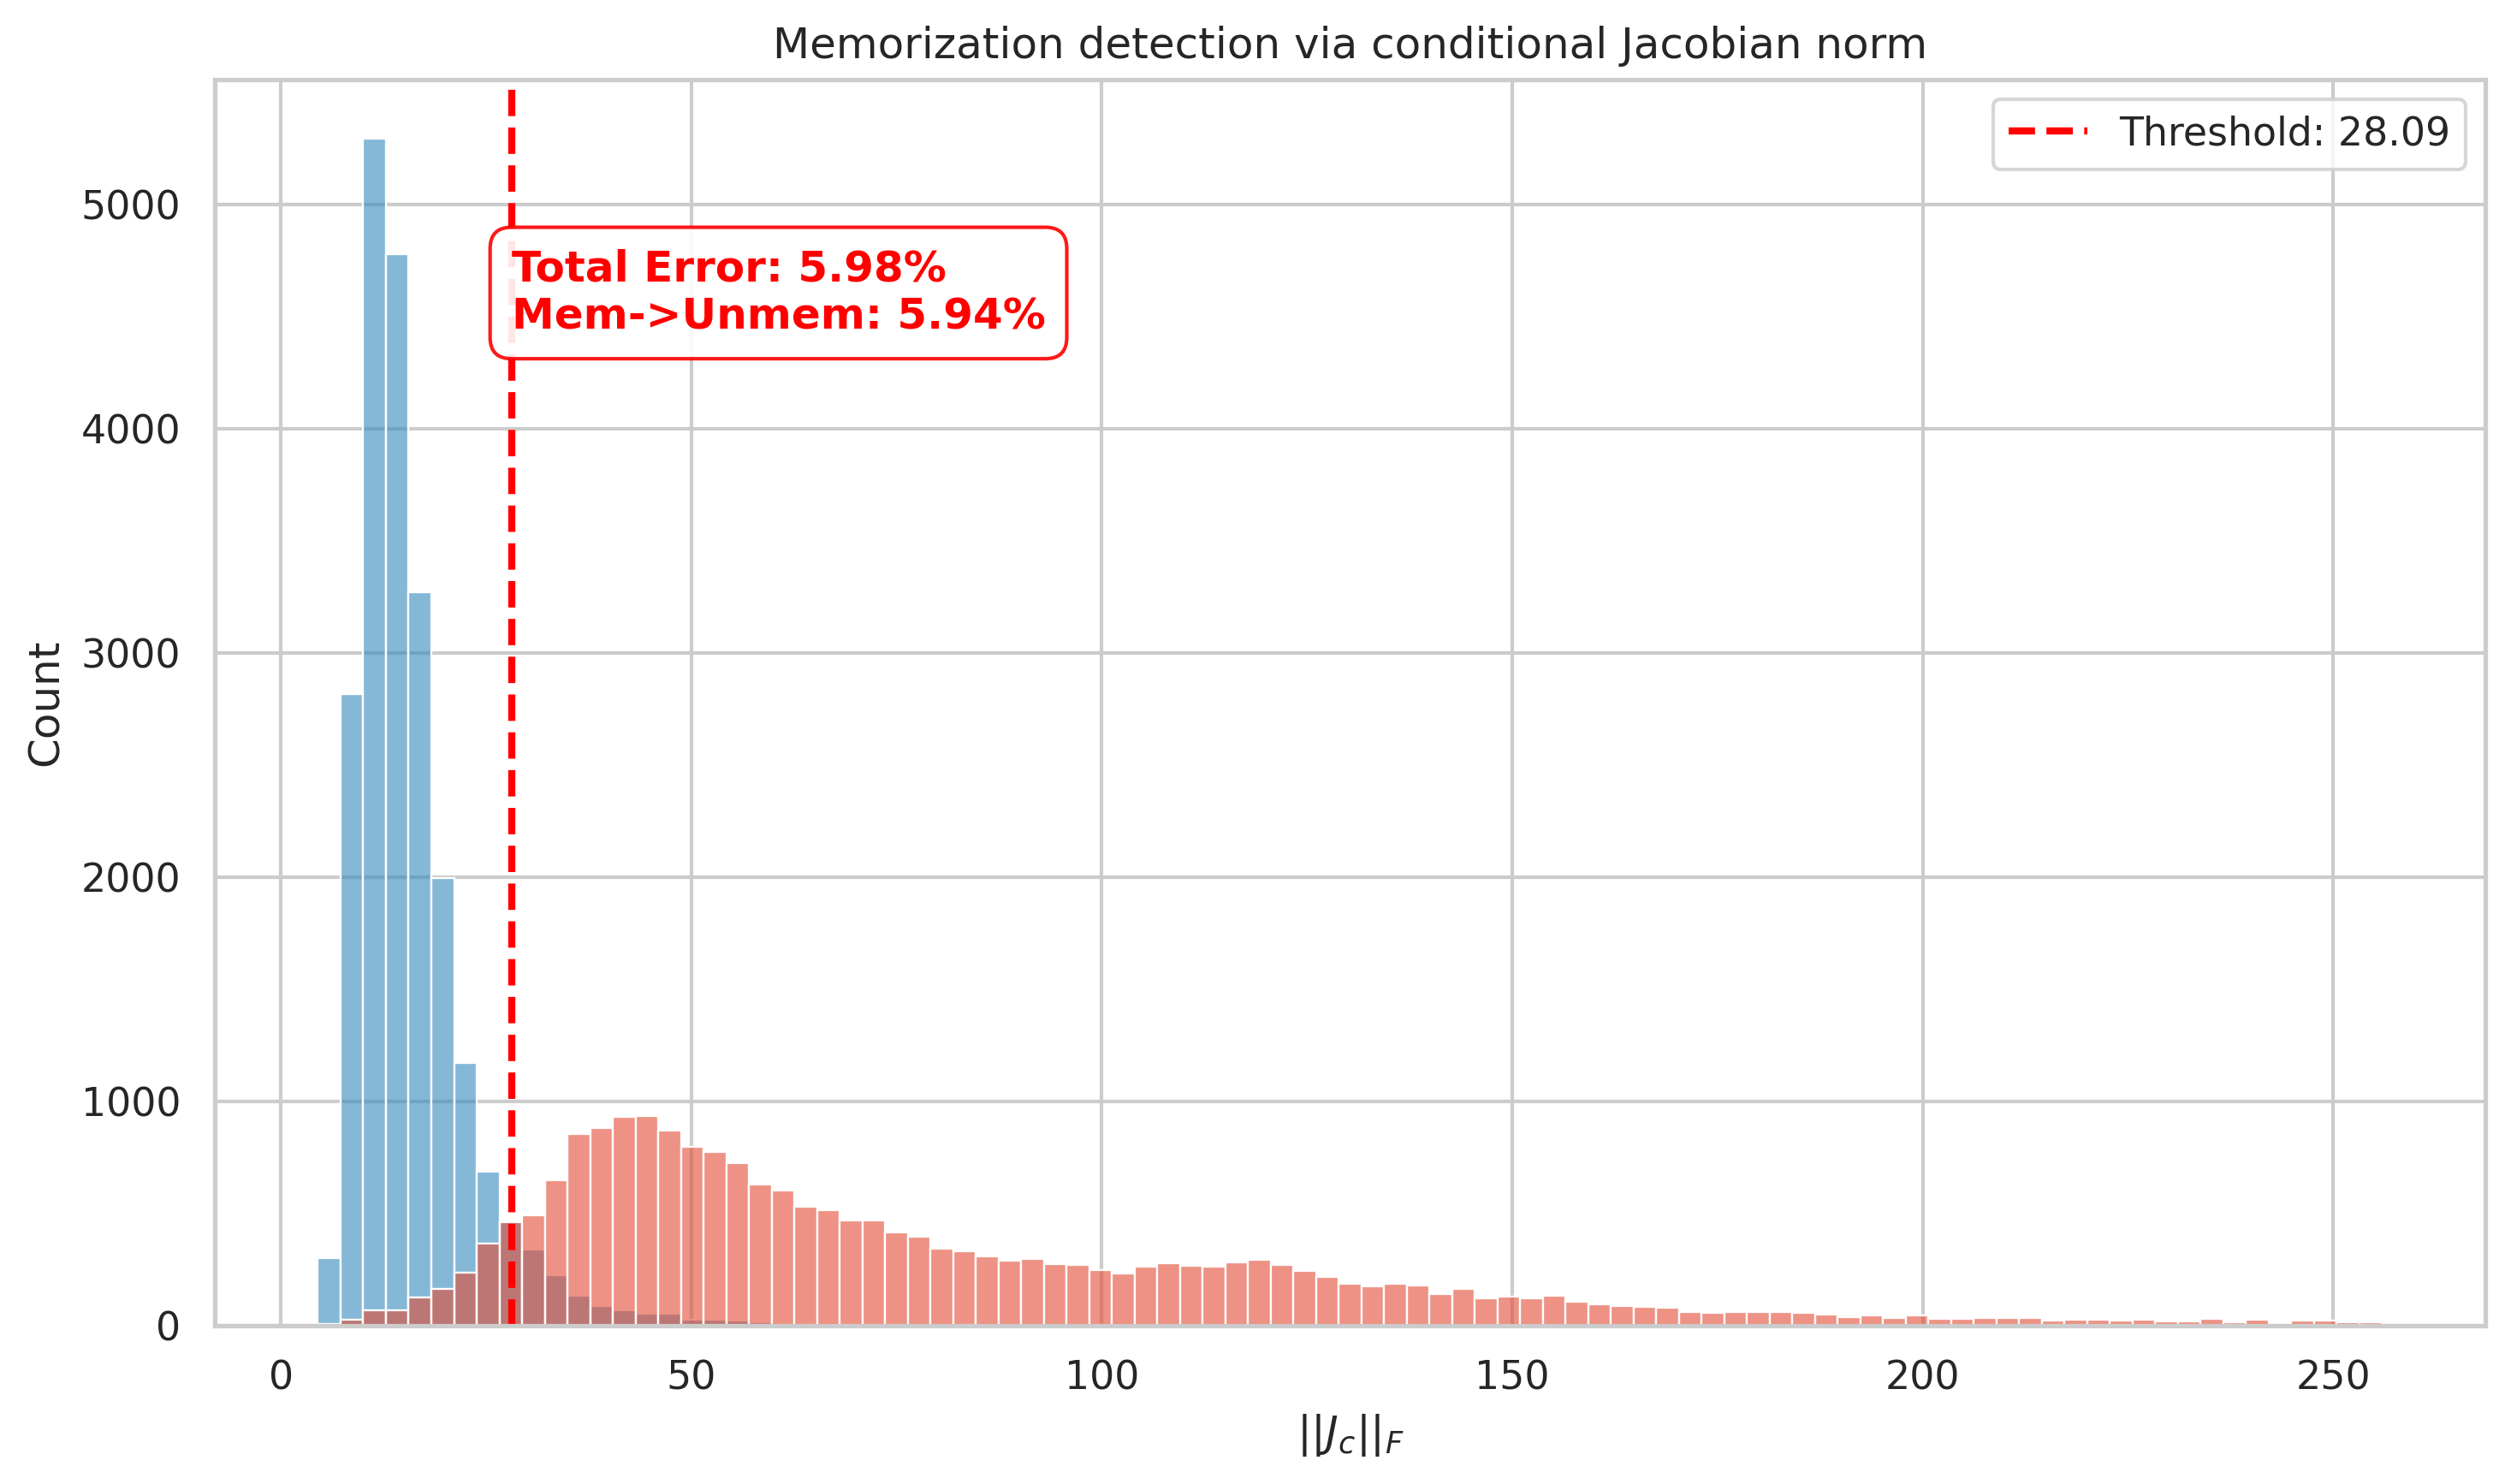

In [22]:
# 1. Plot (Sample Level)
plt.figure(figsize=(10, 6), dpi=300)

sns.histplot(
    data=df_results, 
    x="JacobianNorm", 
    hue="Group", 
    kde=False,           
    element="bars",      
    stat="count",        
    common_norm=False,   
    multiple="layer",    
    alpha=0.6,           
    palette=["#E24A33", "#348ABD"] 
)

# Threshold Line (Red)
plt.axvline(x=thresh_sample, color='red', linestyle='--', linewidth=2, label=f"Threshold: {thresh_sample:.2f}")

# Error Text (Red)
y_lim = plt.ylim()
text_x = thresh_sample
text_y = y_lim[1] * 0.80

error_text = f"Total Error: {overall_error_sample:.2f}%\nMem->Unmem: {mem_unmem_error_sample:.2f}%"

plt.text(text_x, text_y, error_text, 
         color='red', 
         fontsize=12, 
         fontweight='bold',
         bbox=dict(facecolor='white', alpha=0.9, edgecolor='red', boxstyle='round,pad=0.5'))

plt.xlabel(r"$||J_c||_F$")
plt.ylabel("Count")
plt.title("Memorization detection via conditional Jacobian norm")
plt.legend()

plt.tight_layout()
#plt.savefig("jacobian_classification_sample_level.png")
plt.show()

## 2. Prompt-Level Analysis
Averaging Jacobian Norms over 100 samples per prompt.

In [23]:
# 2. Aggregate Data (Prompt Level)
df_prompt = df_results.groupby(["Group", "Caption"])["JacobianNorm"].mean().reset_index()

print(f"Aggregated to {len(df_prompt)} prompts.")

# Calculate Threshold (Prompt Level)
thresh_prompt, acc_prompt, dir_prompt = calculate_optimal_threshold(df_prompt)
overall_error_prompt = (1 - acc_prompt) * 100

# Calculate Mem -> Unmem Error (False Negative Rate) for Prompts
mem_data_p = df_prompt[df_prompt["Group"] == "Memorized"]
n_mem_p = len(mem_data_p)

if dir_prompt == "greater":
    n_mem_err_p = (mem_data_p["JacobianNorm"] <= thresh_prompt).sum()
else:
    n_mem_err_p = (mem_data_p["JacobianNorm"] >= thresh_prompt).sum()

mem_unmem_error_prompt = (n_mem_err_p / n_mem_p) * 100

print(f"Prompt Level Results:")
print(f"Threshold: {thresh_prompt:.4f}")
print(f"Total Error: {overall_error_prompt:.2f}%")
print(f"Mem->Unmem Error: {mem_unmem_error_prompt:.2f}%")

Aggregated to 438 prompts.
Prompt Level Results:
Threshold: 28.3613
Total Error: 0.68%
Mem->Unmem Error: 1.37%


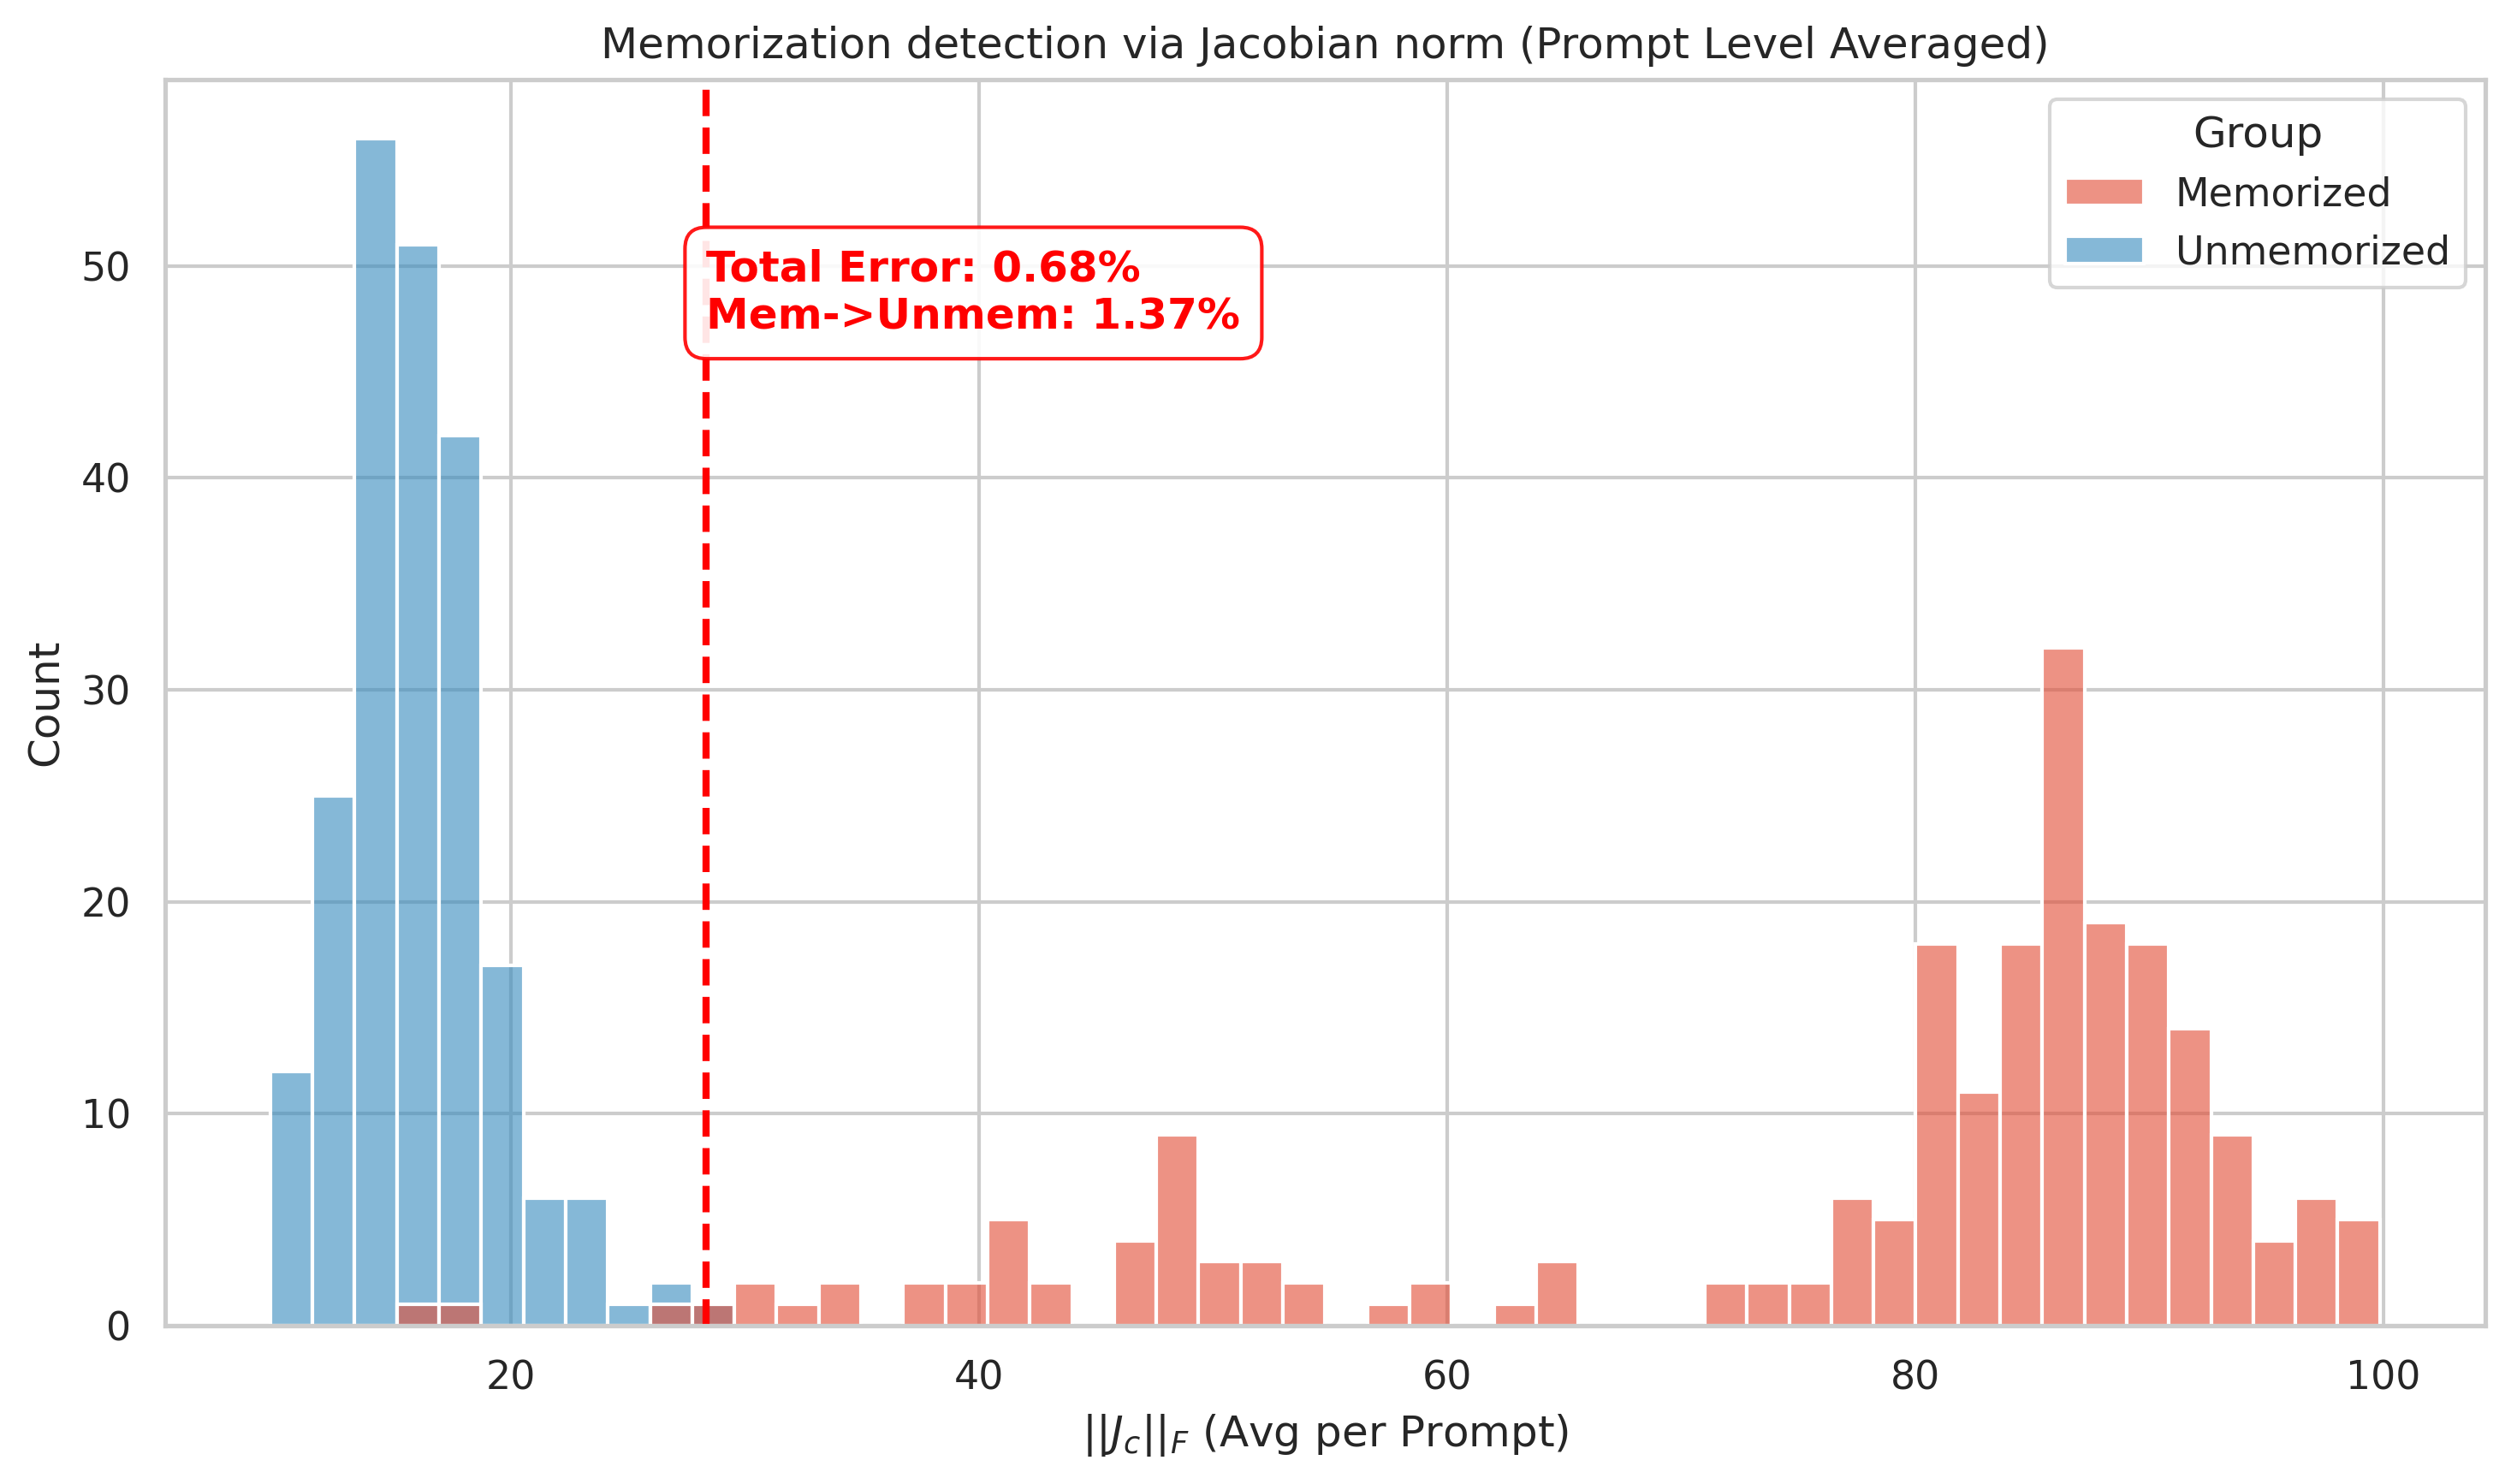

In [24]:
# 2. Plot (Prompt Level)
plt.figure(figsize=(10, 6), dpi=300)

sns.histplot(
    bins=50, 
    data=df_prompt, 
    x="JacobianNorm", 
    hue="Group", 
    kde=False,           
    element="bars",      
    stat="count",        
    common_norm=False,   
    multiple="layer",    
    alpha=0.6,           
    palette=["#E24A33", "#348ABD"] 
)

# Threshold Line (Red)
plt.axvline(x=thresh_prompt, color='red', linestyle='--', linewidth=2, label=f"Threshold: {thresh_prompt:.2f}")

# Error Text (Red)
y_lim = plt.ylim()
text_x = thresh_prompt
text_y = y_lim[1] * 0.80

error_text_p = f"Total Error: {overall_error_prompt:.2f}%\nMem->Unmem: {mem_unmem_error_prompt:.2f}%"

plt.text(text_x, text_y, error_text_p, 
         color='red', 
         fontsize=12, 
         fontweight='bold',
         bbox=dict(facecolor='white', alpha=0.9, edgecolor='red', boxstyle='round,pad=0.5'))

plt.xlabel(r"$||J_c||_F$ (Avg per Prompt)") 
plt.ylabel("Count")
plt.title("Memorization detection via Jacobian norm (Prompt Level Averaged)")

plt.tight_layout()
#plt.savefig("jacobian_classification_prompt_level.png")
plt.show()

Performing ROC Analysis on Sample Level Data (First Plot)...
Sample Level ROC Results:
AUC: 0.9809
TPR at 1% FPR: 0.7061 (at FPR=0.0100)


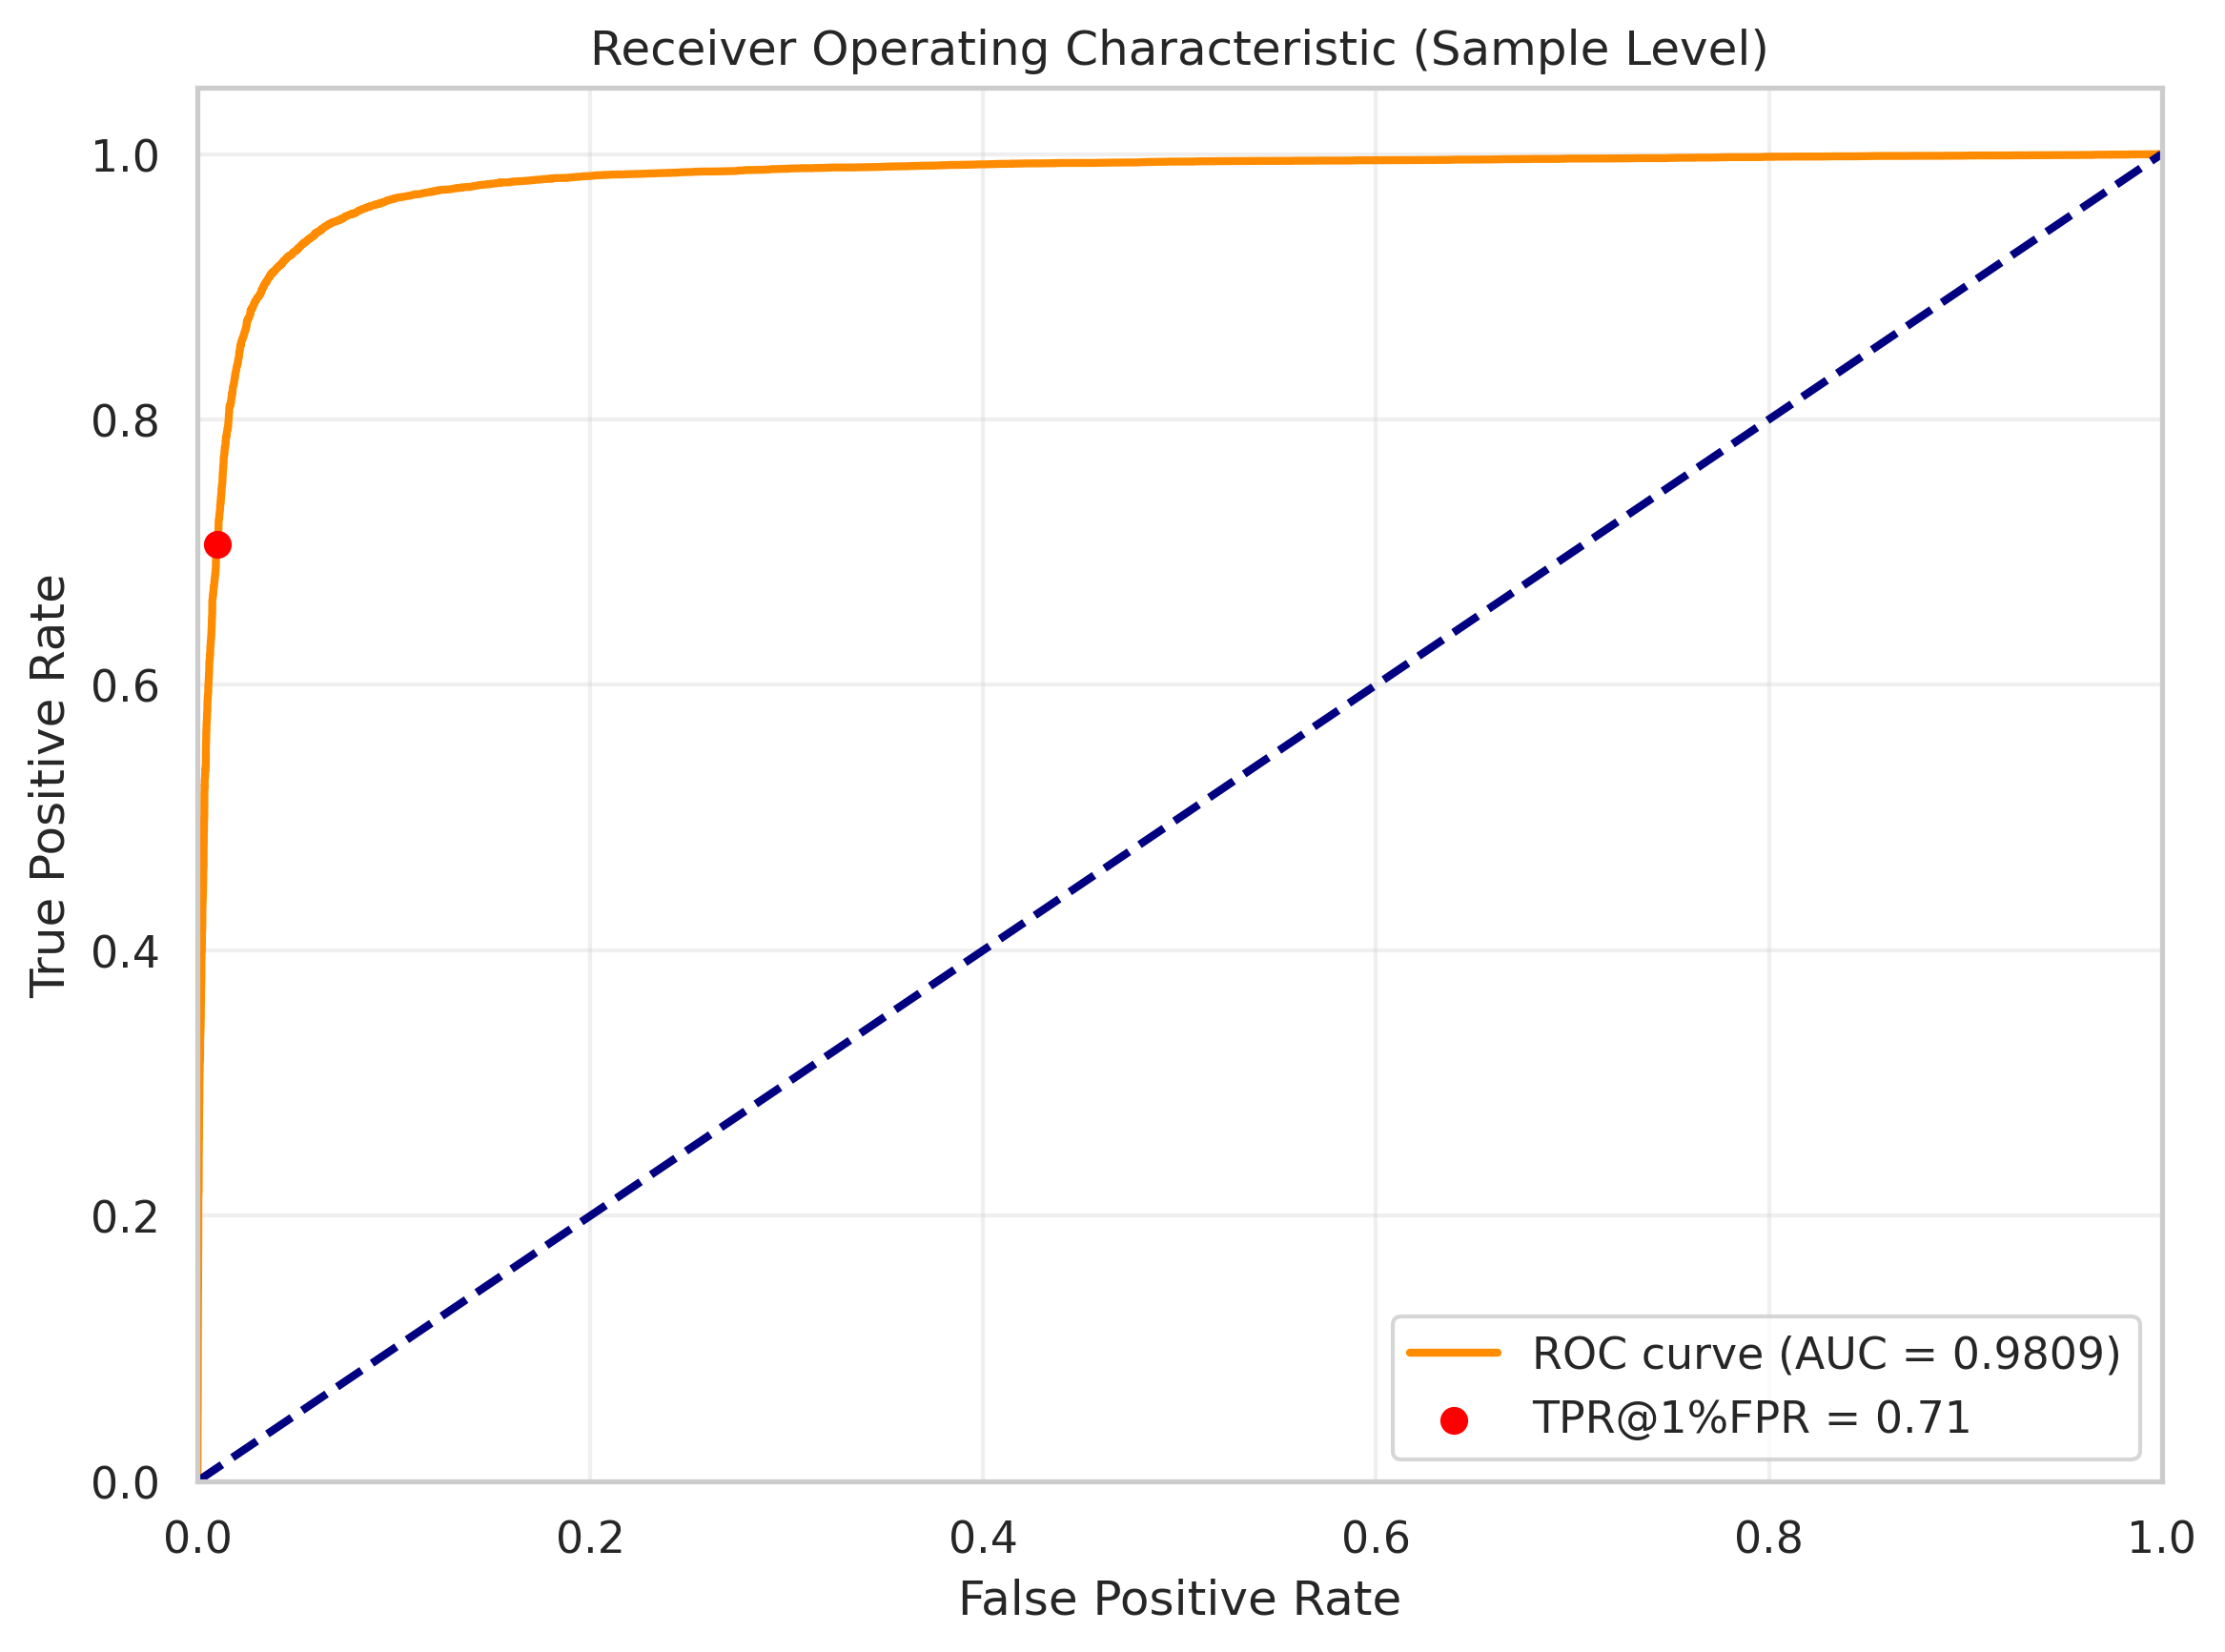

In [25]:

from sklearn.metrics import roc_curve, auc

print("Performing ROC Analysis on Sample Level Data (First Plot)...")

# Prepare data
y_true = (df_results["Group"] == "Memorized").astype(int)
y_scores = df_results["JacobianNorm"]

# Calculate ROC and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Check directionality. If AUC < 0.5, it implies Memorized samples have lower values than Unmemorized.
# In that case, we invert the scores to interpret "Memorized" as the positive class correctly.
if roc_auc < 0.5:
    y_scores = -y_scores
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

# Calculate TPR at 1% FPR
# We find the thresholds where FPR <= 0.01
valid_indices = np.where(fpr <= 0.01)[0]
if len(valid_indices) > 0:
    # The last index where FPR <= 0.01 corresponds to the highest TPR for that FPR constraint
    idx_1pct = valid_indices[-1]
    tpr_at_1pct_fpr = tpr[idx_1pct]
    actual_fpr = fpr[idx_1pct]
else:
    tpr_at_1pct_fpr = 0.0
    actual_fpr = 0.0

print(f"Sample Level ROC Results:")
print(f"AUC: {roc_auc:.4f}")
print(f"TPR at 1% FPR: {tpr_at_1pct_fpr:.4f} (at FPR={actual_fpr:.4f})")

# Plot ROC Curve
plt.figure(figsize=(8, 6), dpi=300)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(actual_fpr, tpr_at_1pct_fpr, color='red', zorder=5, label=f'TPR@1%FPR = {tpr_at_1pct_fpr:.2f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Sample Level)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("jacobian_classification_sample_roc.png")
plt.show()



Performing ROC Analysis on 25 Non-Overlapping Groups of 4 Samples per Prompt...
25-Fold Subsampling (k=4) ROC Results (Treating each fold as independent):
AUC: 0.9757
TPR at 1% FPR: 0.8362 (at FPR=0.0099)


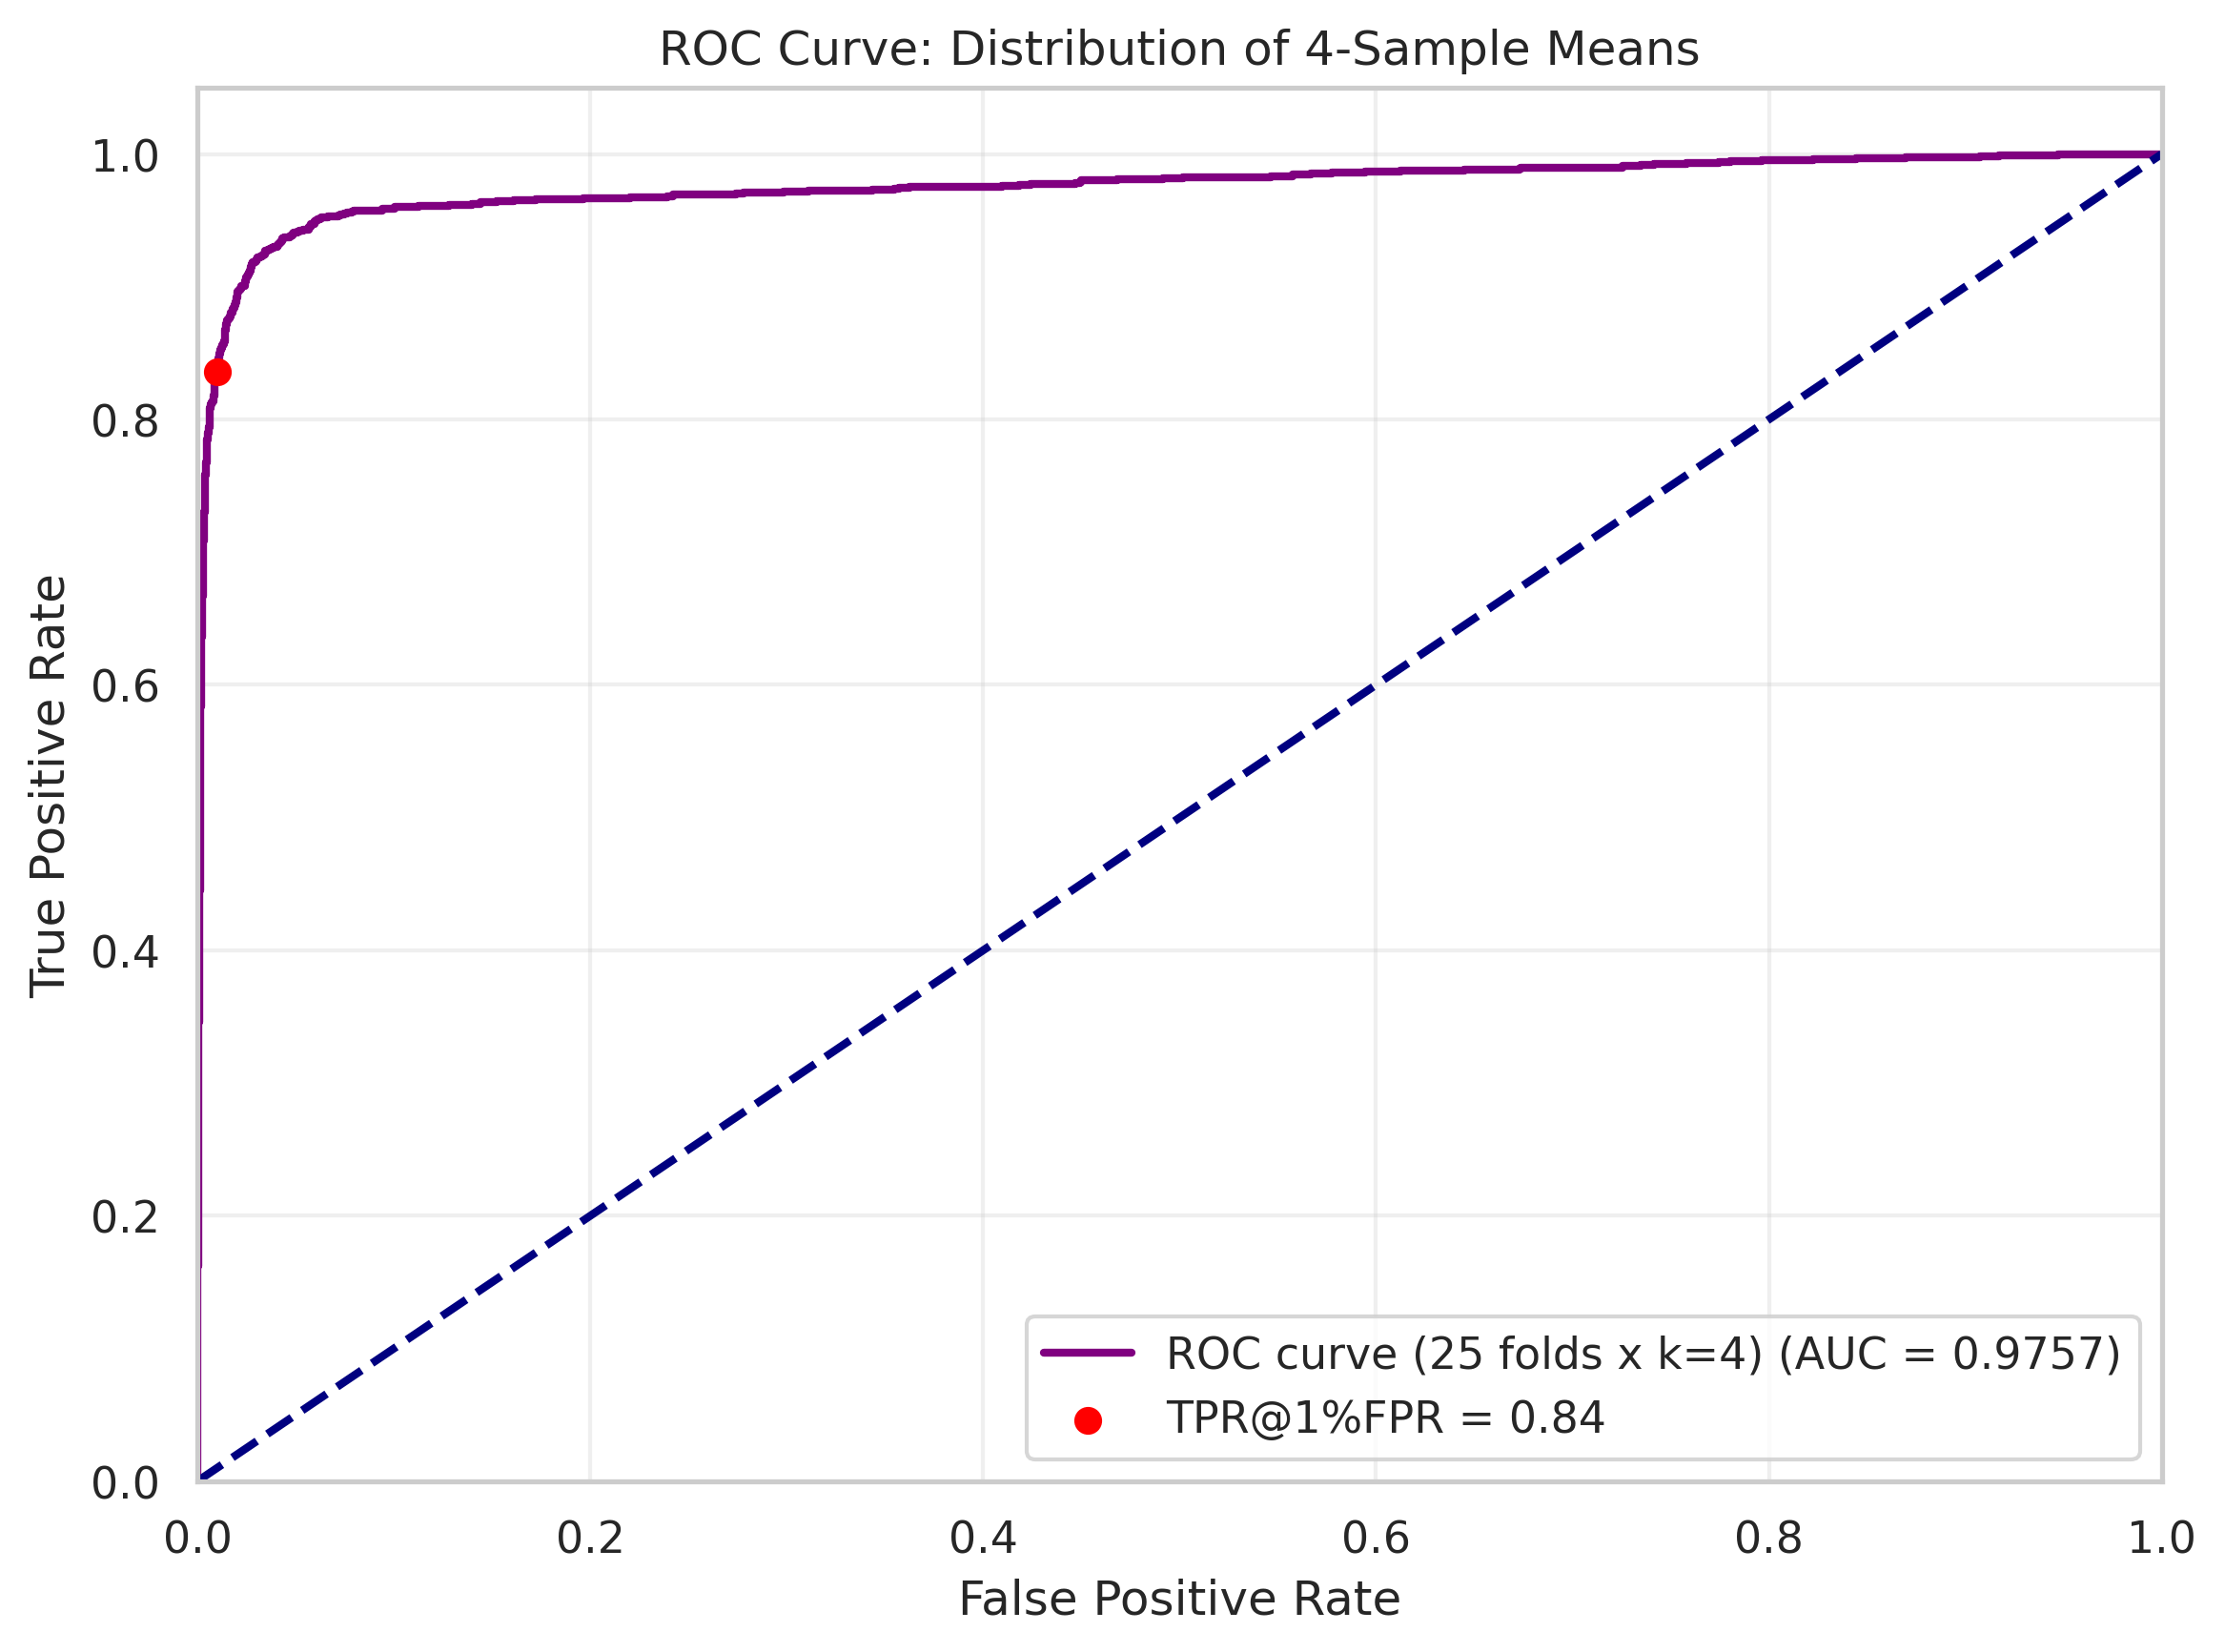


--- 25 Group Means & Grand Mean (Showing first 5 prompts) ---
Prompt: Bella and Canvas Short-Sleeve ... (Memorized)
  Grand Mean: 88.2913
  25 Group Means (k=4): [ 76.604 136.894  49.83   41.323  89.266 100.392 132.392  65.51  101.776
 106.113 123.563  84.594 105.735 100.758  62.251  86.323  77.58   71.543
  97.253  83.162  86.783  75.916  73.479  72.549 105.695]
--------------------------------------------------
Prompt: DEATH METAL! (Funny Unicorn / ... (Memorized)
  Grand Mean: 34.7779
  25 Group Means (k=4): [24.541 33.111 56.671 28.743 30.275 53.535 45.165 41.733 25.469 31.522
 12.972 43.575 37.594 26.105 27.736 58.332 43.262 27.409 41.689 25.205
 22.701 46.111 15.65  38.612 31.73 ]
--------------------------------------------------
Prompt: Design Art Dark Morning In For... (Memorized)
  Grand Mean: 51.8256
  25 Group Means (k=4): [46.553 48.521 46.84  53.672 43.549 50.558 65.549 54.644 51.781 45.157
 61.968 47.701 42.276 51.596 48.664 49.286 49.161 51.585 69.616 51.558
 60.239 47

In [33]:

# --- ROC Analysis for Subsampling (25 groups of 4 non-overlapping) ---
print("\nPerforming ROC Analysis on 25 Non-Overlapping Groups of 4 Samples per Prompt...")

from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Group by Prompt
grouped = df_results.groupby(["Group", "Caption"])["JacobianNorm"].apply(lambda x: np.array(x))

y_true_all_groups = []
y_scores_all_groups = []

# To store results for display (25 values per prompt)
results_display = []

np.random.seed(42)

for (group, caption), norms in grouped.items():
    if len(norms) >= 100: # Need at least 100 samples
        # Shuffle to ensure randomness, then split into 25 chunks of 4
        shuffled_norms = np.random.permutation(norms)[:100]
        chunks = np.array_split(shuffled_norms, 25)
        
        prompt_means = []
        for chunk in chunks:
            mean_val = np.mean(chunk)
            prompt_means.append(mean_val)
        
        # MOVED OUTSIDE THE LOOP
        y_true_all_groups.extend([1 if group == "Memorized" else 0] * 25)
        y_scores_all_groups.extend(prompt_means)
        
        # Store for display (example: first few prompts)
        if len(results_display) < 5:
             results_display.append({
                "Prompt": caption[:30] + "...",
                "Group": group,
                "25_Means": prompt_means,
                "Grand_Mean": np.mean(prompt_means)
            })

y_true_all_groups = np.array(y_true_all_groups)
y_scores_all_groups = np.array(y_scores_all_groups)

# Calculate ROC and AUC (aggregating all 25 trials per prompt)
fpr_25, tpr_25, thresholds_25 = roc_curve(y_true_all_groups, y_scores_all_groups)
roc_auc_25 = auc(fpr_25, tpr_25)

# Check directionality
if roc_auc_25 < 0.5:
    y_scores_all_groups = -y_scores_all_groups
    fpr_25, tpr_25, thresholds_25 = roc_curve(y_true_all_groups, y_scores_all_groups)
    roc_auc_25 = auc(fpr_25, tpr_25)

# Calculate TPR at 1% FPR
valid_indices_25 = np.where(fpr_25 <= 0.01)[0]
if len(valid_indices_25) > 0:
    idx_1pct_25 = valid_indices_25[-1]
    tpr_at_1pct_fpr_25 = tpr_25[idx_1pct_25]
    actual_fpr_25 = fpr_25[idx_1pct_25]
else:
    tpr_at_1pct_fpr_25 = 0.0
    actual_fpr_25 = 0.0

print(f"25-Fold Subsampling (k=4) ROC Results (Treating each fold as independent):")
print(f"AUC: {roc_auc_25:.4f}")
print(f"TPR at 1% FPR: {tpr_at_1pct_fpr_25:.4f} (at FPR={actual_fpr_25:.4f})")

# Plot ROC Curve
plt.figure(figsize=(8, 6), dpi=300)
plt.plot(fpr_25, tpr_25, color='purple', lw=2, label=f'ROC curve (25 folds x k=4) (AUC = {roc_auc_25:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(actual_fpr_25, tpr_at_1pct_fpr_25, color='red', zorder=5, label=f'TPR@1%FPR = {tpr_at_1pct_fpr_25:.2f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Distribution of 4-Sample Means')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("jacobian_classification_subsample_25folds_roc.png")
plt.show()

# Display Values
print("\n--- 25 Group Means & Grand Mean (Showing first 5 prompts) ---")
for i, res in enumerate(results_display):
    print(f"Prompt: {res['Prompt']} ({res['Group']})")
    print(f"  Grand Mean: {res['Grand_Mean']:.4f}")
    print(f"  25 Group Means (k=4): {np.round(res['25_Means'], 3)}")
    print("-" * 50)
